# Unsupervised federated learning: K-means clustering

The present notebook tackles the problem of *unsupervised* learning in a federated configuration. 
In particular, a K-Means clustering is used from the `sklearn` library (see [this link](https://scikit-learn.org/stable/modules/clustering.html#k-means)).

The framework provides some functions to load the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset.

(135, 4)
(15, 4)


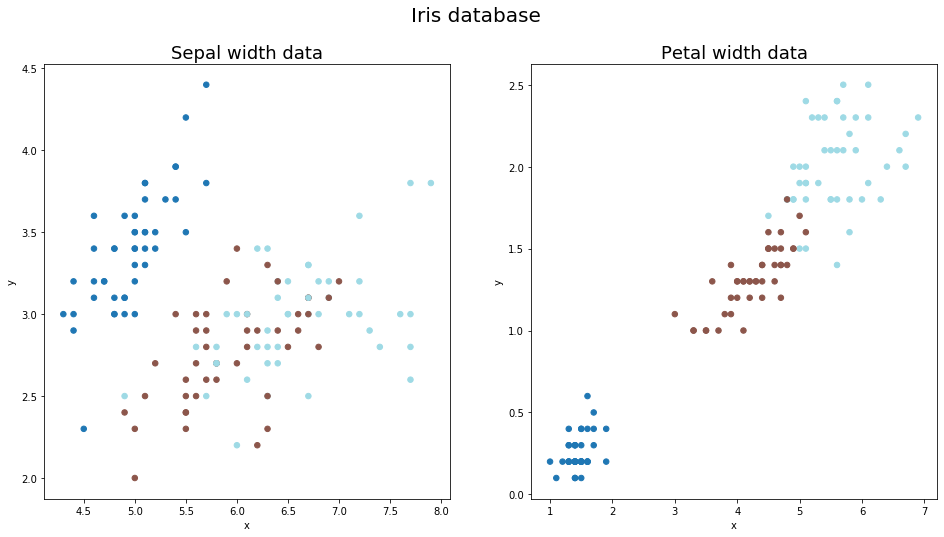

In [1]:
import matplotlib.pyplot as plt
import shfl
import numpy as np
from shfl.data_base.iris import Iris


# Assign database:    
database = Iris()

train_data, train_labels, test_data, test_labels = database.load_data()
print(train_data.shape)
print(test_data.shape)

# Visualize train data: 
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('Sepal width data', fontsize=18)
ax[0].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=30, cmap="tab20")
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_title('Petal width data', fontsize=18)
ax[1].scatter(train_data[:, 2], train_data[:, 3], c=train_labels, s=30, cmap="tab20")
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
fig.suptitle("Iris database", fontsize=20)
plt.show()

We implement a method to plot K-Means results in Iris database and establish a centralised model which will be our reference model. 

[[4.96444444 3.39333333 1.45777778 0.24888889]
 [6.88823529 3.07647059 5.77352941 2.05      ]
 [5.90357143 2.74464286 4.40535714 1.44285714]]


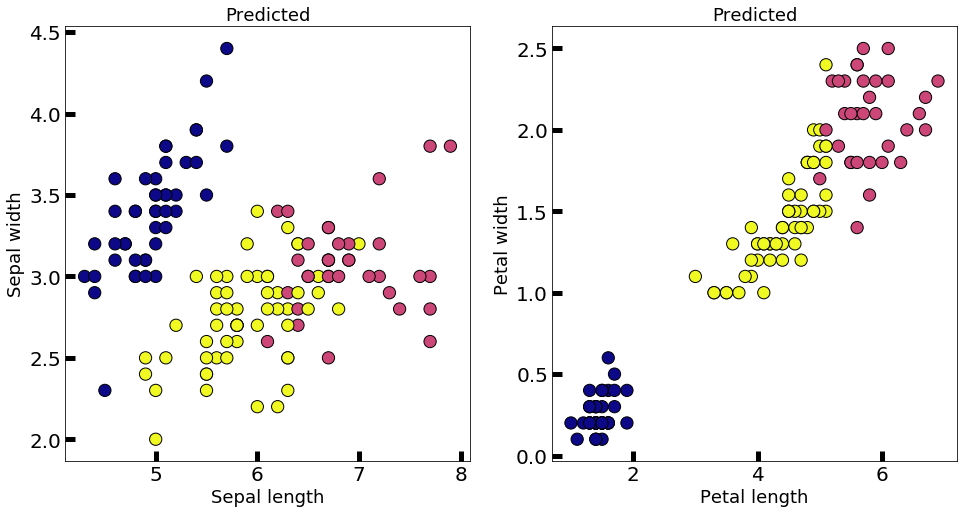

In [2]:
from shfl.model.kmeans_model import KMeansModel

def plot_k_means(km, X, title):
    new_labels = km.predict(X)
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    axes[0].scatter(X[:, 0], X[:, 1], c=new_labels, cmap='plasma',
    edgecolor='k', s=150)
    axes[1].scatter(X[:, 2], X[:, 3], c=new_labels, cmap='plasma',
    edgecolor='k', s=150)
    axes[0].set_xlabel('Sepal length', fontsize=18)
    axes[0].set_ylabel('Sepal width', fontsize=18)
    axes[1].set_xlabel('Petal length', fontsize=18)
    axes[1].set_ylabel('Petal width', fontsize=18)
    axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
    axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
    axes[0].set_title('Predicted', fontsize=18)
    axes[1].set_title('Predicted', fontsize=18)
    
# Plot train data:
centralized_model = KMeansModel(n_clusters=3, n_features = train_data.shape[1], init = np.zeros((3,4)))
centralized_model.train(train_data)

print(centralized_model.get_model_params())
plot_k_means(centralized_model, train_data, title = "Benchmark: K-means using centralized data")

**How to aggregate model's parameters from each federated node in clustering** <br/>

Since the labels of clusters can vary among each node, we cannot average the centroids right away. 
A solution is to choose the lowest distance average: this is achieved by simply applying the k-means algorithm on the centroids coordinates of all nodes. 
In [ClusterFedAvgAggregator](../shfl/federated_aggregator/cluster_fedavg_aggregator.py) you can see its implementation.

**Remark**: this implementation is based on the assumption that the number of clusters is previously fixed across the clients, so it only works properly in I.I.D scenarios (see [Federated Sampling](./federated_sampling.ipynb)). We are working in a federated aggregation operator which works in every distribution of data across clients.

In [3]:
from shfl.federated_aggregator.cluster_fedavg_aggregator import ClusterFedAvgAggregator

# Create the IID data: 
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes = 12, percent=100)
print("Number of nodes: " + str(federated_data.num_nodes()))

# Run the algorithm:
aggregator = ClusterFedAvgAggregator()

Number of nodes: 12


We are now ready to run our model in a federated configuration. 

The performance is assessed by several clustering metrics (see [this link](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)).

For reference, below we compare the metrics of:
 - Each node; 
 - The global (federated) model;
 - The centralized (non-federated) model.
 
It can be observed that the performance of *Global federated model* is in general superior with respect to the performance of each node, thus the federated learning approach proves to be beneficial. Moreover, the performance of the Global federated model is very close to the performance of the centralized model.

Test data size: 15


Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a898d0>: (0.8236365430725701, 0.8563305124226224, 0.839665397809165, 0.7996608013567946)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89110>: (1.0, 1.0, 1.0, 1.0)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89650>: (1.0, 1.0, 1.0, 1.0)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89c90>: (0.6480717762670881, 0.824250251858952, 0.7256202306376103, 0.5786355818841965)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89790>: (1.0, 1.0, 1.0, 1.0)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89dd0>: (0.648071776267088, 0.8242502518589518, 0.7256202306376103, 0.5786355818841965)
Test performance client <shfl.private.federated_opera

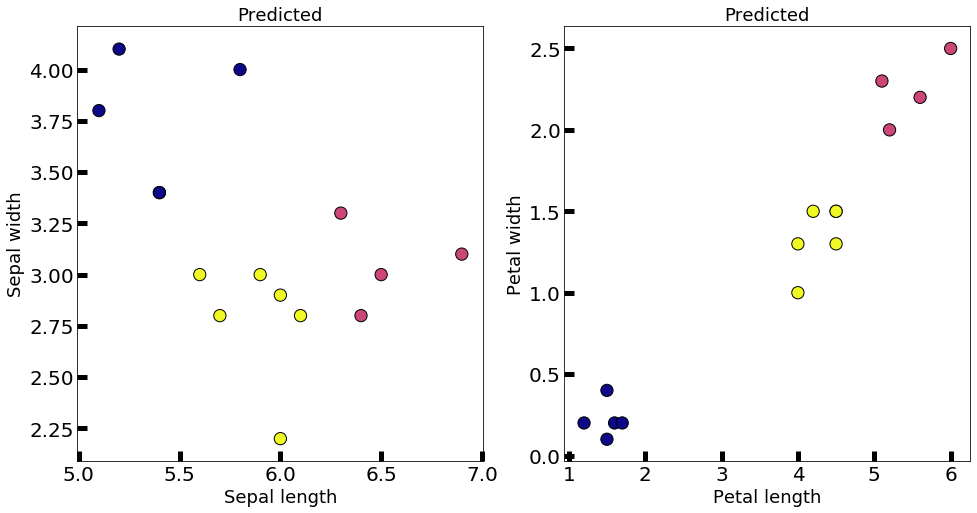

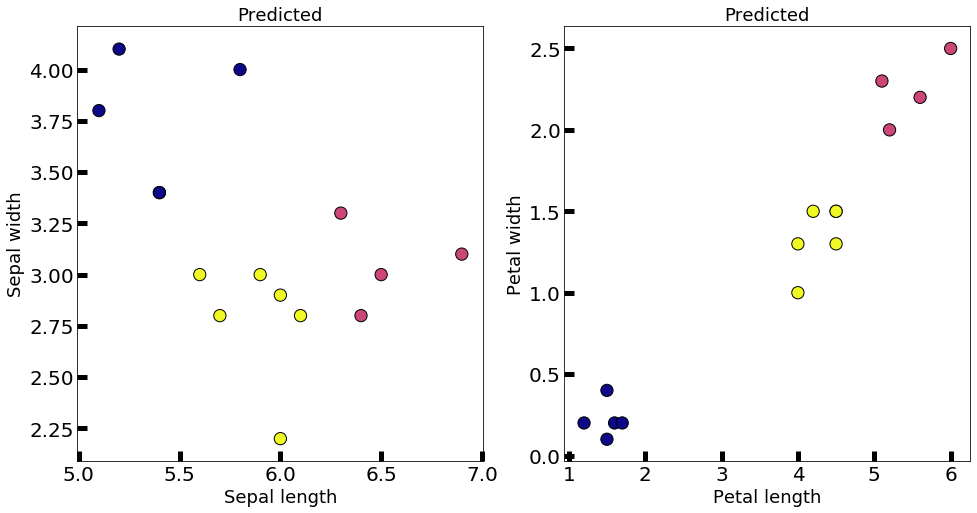

In [4]:
from shfl.federated_government.federated_government import FederatedGovernment

n_clusters = 3 # Set number of clusters
n_features = train_data.shape[1]
def model_builder():
    model = KMeansModel(n_clusters=n_clusters, n_features = n_features)
    return model


federated_government = FederatedGovernment(model_builder, federated_data, aggregator)
print("Test data size: " + str(test_data.shape[0]))
print("\n")
federated_government.run_rounds(n = 3, test_data = test_data, test_label = test_label)

# Reference Centralized (non federate) model:
print("Centralized model test performance : " + str(centralized_model.evaluate(data=test_data, labels=test_labels)))
plot_k_means(centralized_model, test_data, title = "Benchmark on Test data: K-means using CENTRALIZED data")
plot_k_means(federated_government.global_model, test_data, title = "Benchmark on Test data: K-means using FL")

**Differentially Private version**

To preserve the privacy of the clients, in this section we introduce Differential Privacy (DP) in our model. Firstly we calibrate the noise introduced by the differentially private mechanism using the test data, then we apply DP to each client feature, so that each cluster computed by a client is shared with the main server privately, that is, without disclosing client's identity.

In the case of applying the Laplace privacy mechanism , the noise added has to be of the order of the sensitivity of the model's output, i.e. the coordinates of each cluster.

In the general case, the model's sensitivity might be difficult to compute analytically. 
An alternative approach is to attain *random* differential privacy through a sampling over the data.

That is, instead of computing analytically the *global* sensitivity $\Delta f$, we compute an *empirical estimation* of it by sampling over the dataset.
This approach is very convenient since allows for the sensitivity estimation of an arbitrary model or a black-box computer function.
The \texttt{Sherpa.FL} framework provides this functionality in the class `SensitivitySampler`.

In order to carry out this approach, we need to specify a distribution of the data to sample from. 
This in general requires previous knowledge and/or model assumptions. 
However, in our specific case of manufactured data, we may assume that the data distribution is *uniform*. 
To the end, we define our class of `ProbabilityDistribution` that uniformly samples over a data-frame.
Moreover, we assume that we do have access to a set of data (this can be thought, for example, as some reference public data set). 
In this example, we generate a $\textit{new}$ dataset, and use its train partition for sampling:


In [5]:
import numpy as np

class UniformDistribution(shfl.differential_privacy.ProbabilityDistribution):
    """
    Implement Uniform sampling over the data
    """
    def __init__(self, sample_data):
        self._sample_data = sample_data

    def sample(self, sample_size):
        row_indices = np.random.randint(low=0, high=self._sample_data.shape[0], size=sample_size, dtype='l')
        
        return self._sample_data[row_indices, :]
    
sample_data = test_data

The class `SensitivitySampler` implements the sampling given a *query*, i.e. the learning model itself in this case.
We only need to add the method `get` to our model since it is required by the class `SensitivitySampler`. 
We choose the sensitivity norm to be the v norm and we apply the sampling. 
The value of the sensitivity depends on the number of samples `n`: the more samples we perform, the more accurate the sensitivity. 
Indeed, increasing the number of samples `n`, the sensitivity gets more accurate and typically decreases. 

Unfortunately, sampling over a dataset involves, at each sample, the training of the model on two datasets differing in one entry.
Thus in general this procedure might be computationally expensive (e.g. in the case of training a deep neuronal network).

In [6]:
from shfl.differential_privacy import SensitivitySampler
from shfl.differential_privacy import L1SensitivityNorm

class KMeansSample(KMeansModel):
    
    def __init__(self, feature, **kargs):
        self._feature = feature
        super().__init__(**kargs)
    
    def get(self, data_array):
        self.train(data_array)
        params = self.get_model_params()
        return params[:, self._feature]

distribution = UniformDistribution(sample_data)
sampler = SensitivitySampler()
# Reproducibility
np.random.seed(789)
n_samples = 5000

sensitivities = np.empty(n_features)

for i in range(n_features):
    model = KMeansSample(feature=i, n_clusters=n_clusters, n_features=n_features)
    sensitivities[i], _ = sampler.sample_sensitivity(model, L1SensitivityNorm(), distribution, n=n_samples, gamma=0.05)


In [7]:
print("Max sensitivity from sampling: ", np.max(sensitivities))
print("Min sensitivity from sampling: ", np.min(sensitivities))
print("Mean sensitivity from sampling:", np.mean(sensitivities))

Max sensitivity from sampling:  8.014661909426884
Min sensitivity from sampling:  1.9891912265158287
Mean sensitivity from sampling: 4.108693173452301


In [8]:
from shfl.differential_privacy import LaplaceMechanism
from shfl.private.data import DPDataAccessDefinition

class CustomAccess(DPDataAccessDefinition):
    
    def __init__(self, sensitivity_array, epsilon):
        self._epsilon = epsilon
        self._sensitivity_array = sensitivity_array

    @property    
    def epsilon_delta(self):
        return self._epsilon, 0
    
    def apply(self, data):
        for i in range(len(self._sensitivity_array)):
            dpm = LaplaceMechanism(sensitivity=self._sensitivity_array[i], epsilon=self._epsilon)
            data[:,i] = dpm.apply(data[:,i])
        return data

Generally if the model has more than one feature, it is a bad idea to estimate the sensitivity for all of the features at the same time as the features may have wildly varying sensitivities.

Test data size: 15


Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a898d0>: (0.8236365430725703, 0.8563305124226227, 0.8396653978091654, 0.7996608013567946)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89110>: (1.0, 1.0, 1.0, 1.0)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89650>: (1.0, 1.0, 1.0, 1.0)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89c90>: (0.6480717762670881, 0.824250251858952, 0.7256202306376103, 0.5786355818841965)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89790>: (1.0, 1.0, 1.0, 1.0)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89dd0>: (0.6480717762670881, 0.824250251858952, 0.7256202306376103, 0.5786355818841965)
Test performance client <shfl.private.federated_oper

Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89790>: (0.5865470395548533, 0.7923593947577408, 0.6740936813313461, 0.460352422907489)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89dd0>: (0.5865470395548532, 0.7394007551385607, 0.6541634983018686, 0.412532637075718)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a89f10>: (0.5865470395548533, 0.7923593947577408, 0.6740936813313461, 0.460352422907489)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a61b50>: (0.5865470395548533, 1.0000000000000004, 0.7394007551385609, 0.5516014234875445)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a619d0>: (0.5865470395548533, 1.0000000000000004, 0.7394007551385609, 0.5516014234875445)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x1a29a

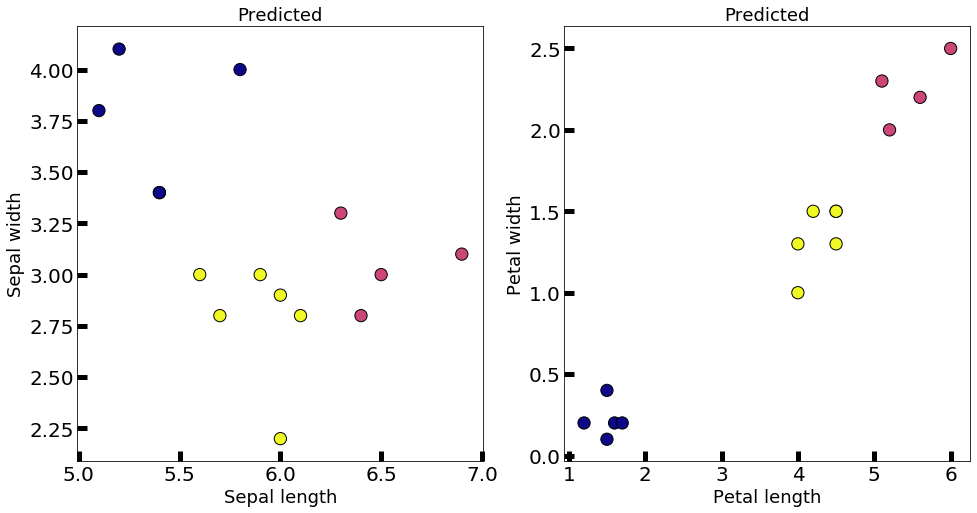

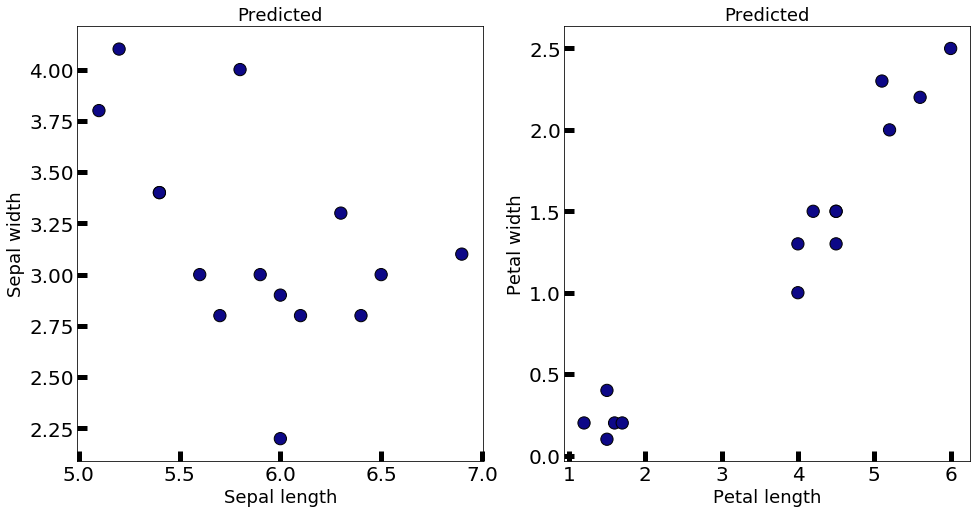

In [10]:
from shfl.differential_privacy.composition_dp import AdaptiveDifferentialPrivacy
from shfl.differential_privacy.composition_dp import ExceededPrivacyBudgetError

global_epsilon_delta=(3, 0)
dpm = CustomAccess(sensitivity_array=sensitivities, epsilon=0.5)
default_params_access = AdaptiveDifferentialPrivacy(global_epsilon_delta, differentially_private_mechanism=dpm)
federated_government = FederatedGovernment(
    model_builder, federated_data, aggregator, model_params_access = default_params_access)
print("Test data size: " + str(test_data.shape[0]))
print("\n")
runs = 0
while True:
    try:
        federated_government.run_rounds(n = 1, test_data = test_data, test_label = test_label)
        runs += 1
    except ExceededPrivacyBudgetError:
        print("\n{} rounds were run before completely spending the privacy budget \n".format(runs+1))
        break

# Reference Centralized (non federate) model:
print("Centralized differentially private model test performance : " + str(centralized_model.evaluate(data=test_data, labels=test_labels)))
plot_k_means(centralized_model, test_data, title = "Benchmark on Test data: K-means using CENTRALIZED data")
plot_k_means(federated_government.global_model, test_data, title = "Benchmark on Test data: K-means using FL and DP")